In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [2]:
sns.set(style="whitegrid", context="talk")


In [63]:
DATA_PATH = "data/"

column_names = (
    ["engine_id", "cycle",
     "op_setting_1", "op_setting_2", "op_setting_3"]
    + [f"sensor_{i}" for i in range(1, 22)]
)

train_df = pd.read_csv(
    DATA_PATH + "train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

test_df = pd.read_csv(
    DATA_PATH + "test_FD001.txt",
    sep=r"\s+",
    header=None,
    names=column_names,
    engine="python"
)

rul_df = pd.read_csv(
    DATA_PATH + "RUL_FD001.txt",
    header=None,
    names=["RUL"]
)

# Drop accidental NaNs from parsing
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("Train engines:", train_df["engine_id"].nunique())
print("Test engines:", test_df["engine_id"].nunique())
print("RUL entries:", len(rul_df))


Train engines: 100
Test engines: 100
RUL entries: 100


In [51]:
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [52]:
train_df.describe().T


,count,mean,std,min,25%,50%,75%,max
engine_id,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op_setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op_setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op_setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
sensor_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [53]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [15]:
train_df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')

In [16]:
train_df[['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']].nunique()


engine_id        100
cycle            362
op_setting_1     158
op_setting_2      13
op_setting_3       1
sensor_1           1
sensor_2         310
sensor_3        3012
sensor_4        4051
sensor_5           1
sensor_6           2
sensor_7         513
sensor_8          53
sensor_9        6403
sensor_10          1
sensor_11        159
sensor_12        427
sensor_13         56
sensor_14       6078
sensor_15       1918
sensor_16          1
sensor_17         13
sensor_18          1
sensor_19          1
sensor_20        120
sensor_21       4745
dtype: int64

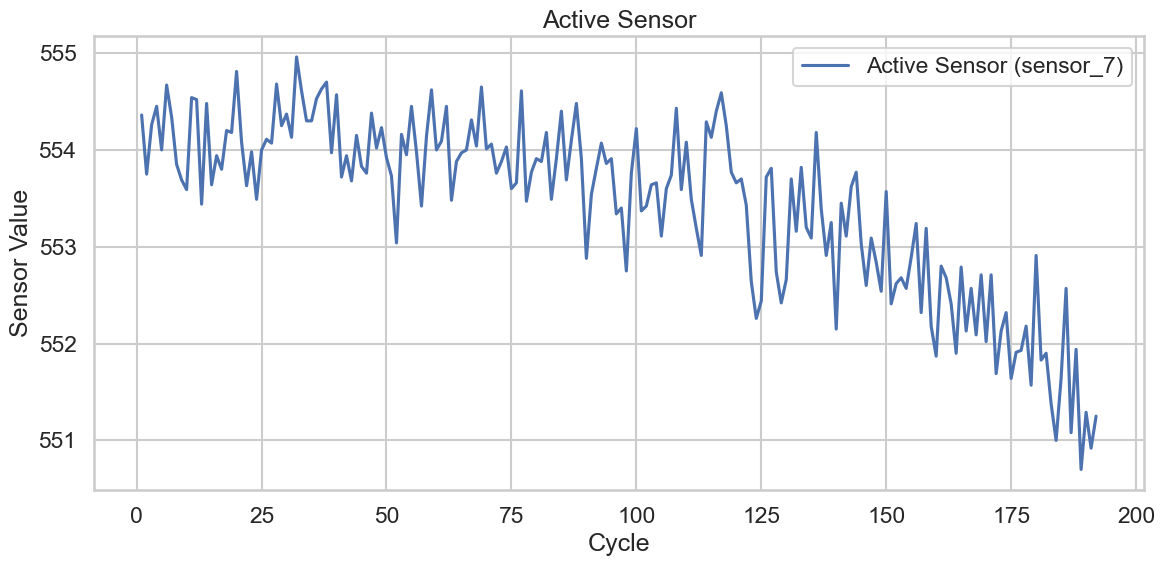

In [64]:

engine_id = 1
engine_data = train_df[train_df["engine_id"] == engine_id]
active_sensor = "sensor_7"
dead_sensor = "sensor_1"

plt.figure(figsize=(12, 6))

sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[active_sensor],
    label=f"Active Sensor ({active_sensor})"
)

# sns.lineplot(
#     x=engine_data["cycle"],
#     y=engine_data[dead_sensor],
#     label=f"Dead Sensor ({dead_sensor})",
#     linestyle="--"
# )

plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.title("Active Sensor")
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Dead sensor(Constant value)')

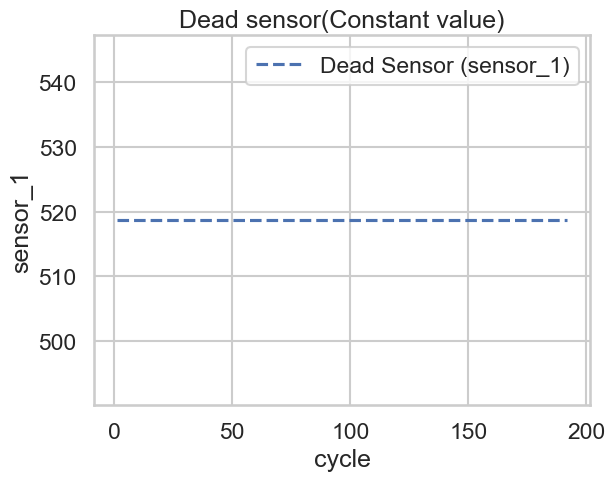

In [65]:
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[dead_sensor],
    label=f"Dead Sensor ({dead_sensor})",
    linestyle="--"
)
plt.title("Dead sensor(Constant value)")

In [66]:
max_cycles = train_df.groupby("engine_id")["cycle"].max()

train_df["RUL_raw"] = (
    max_cycles[train_df["engine_id"]].values
    - train_df["cycle"]
)

# train_df[["engine_id", "cycle", "RUL_raw"]].head()
DEGRADATION_START = 133.7

display_df = train_df[["engine_id", "cycle", "RUL_raw"]].copy()

display_df["phase"] = display_df["RUL_raw"].apply(
    lambda x: "Healthy (Full Life)" if x > DEGRADATION_START else "Degrading Phase"
)

display_df.head(10)




,engine_id,cycle,RUL_raw,phase
0,1,1,191,Healthy (Full Life)
1,1,2,190,Healthy (Full Life)
2,1,3,189,Healthy (Full Life)
3,1,4,188,Healthy (Full Life)
4,1,5,187,Healthy (Full Life)
5,1,6,186,Healthy (Full Life)
6,1,7,185,Healthy (Full Life)
7,1,8,184,Healthy (Full Life)
8,1,9,183,Healthy (Full Life)
9,1,10,182,Healthy (Full Life)


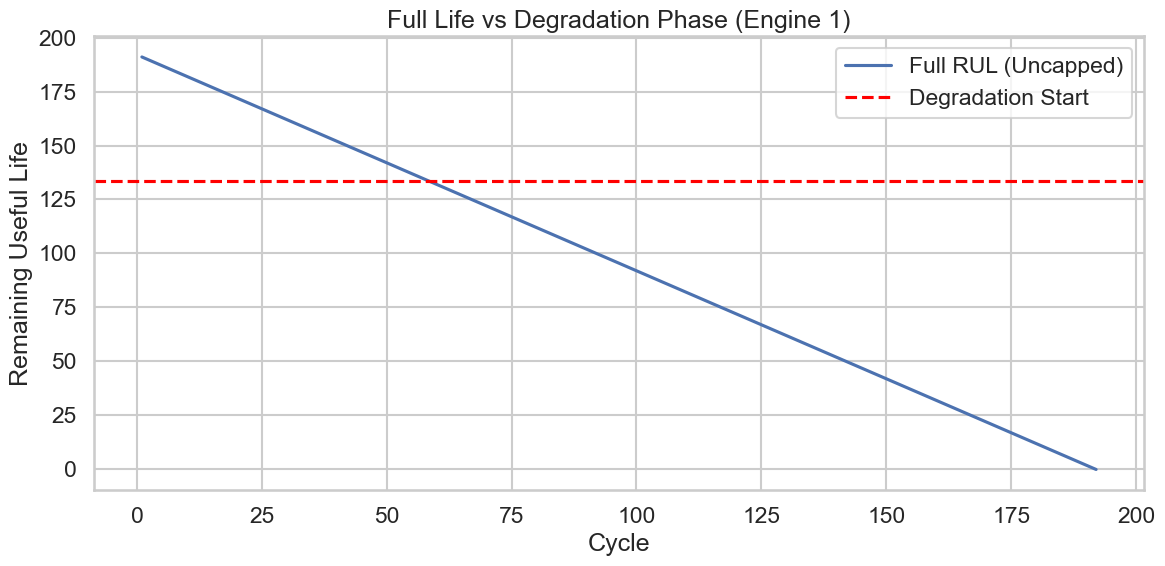

In [67]:
#Show the degradation of engine life over time
engine_id = 1
engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data["RUL_raw"],
    label="Full RUL (Uncapped)"
)

plt.axhline(
    y=DEGRADATION_START,
    color="red",
    linestyle="--",
    label="Degradation Start"
)

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title(f"Full Life vs Degradation Phase (Engine {engine_id})")
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
#capping the RUL to a fixed num
max_cycles = train_df.groupby("engine_id")["cycle"].max()

train_df["RUL"] = train_df.apply(
    lambda row: max_cycles[row["engine_id"]] - row["cycle"],
    axis=1
)
MAX_RUL = 125
train_df["RUL"] = train_df["RUL"].clip(upper=MAX_RUL)
display_df = train_df[["engine_id", "cycle", "RUL"]].copy()

# print(display_df.head())


In [ ]:
feature_cols = [
    col for col in train_df.columns
    if col not in ["engine_id", "cycle", "RUL"]
]

In [ ]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_6","op_setting_3",
    "sensor_10", "sensor_16", "sensor_18", "sensor_19"
]

train_df.drop(columns=drop_sensors, inplace=True)
test_df.drop(columns=drop_sensors, inplace=True)

KeyError: "['op_setting_3sensor_10'] not found in axis"

In [60]:
train_df.columns

Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9',
       'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
       'sensor_17', 'sensor_20', 'sensor_21', 'RUL_raw', 'RUL'],
      dtype='object')

In [ ]:
scaler = MinMaxScaler()

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])


In [47]:
train_df.describe()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL,RUL_raw
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,642.680934,1590.523119,1408.933782,553.367711,2388.096652,...,47.541168,521.413470,2388.096152,8143.752722,8.442146,393.210654,38.816271,23.289705,86.829286,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.500053,6.131150,9.000605,0.885092,0.070985,...,0.267087,0.737553,0.071919,19.076176,0.037505,1.548763,0.180746,0.108251,41.673699,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,641.210000,1571.040000,1382.250000,549.850000,2387.900000,...,46.850000,518.690000,2387.880000,8099.940000,8.324900,388.000000,38.140000,22.894200,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,642.325000,1586.260000,1402.360000,552.810000,2388.050000,...,47.350000,520.960000,2388.040000,8133.245000,8.414900,392.000000,38.700000,23.221800,51.000000,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,642.640000,1590.100000,1408.040000,553.440000,2388.090000,...,47.510000,521.480000,2388.090000,8140.540000,8.438900,393.000000,38.830000,23.297900,103.000000,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,643.000000,1594.380000,1414.555000,554.010000,2388.140000,...,47.700000,521.950000,2388.140000,8148.310000,8.465600,394.000000,38.950000,23.366800,125.000000,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,644.530000,1616.910000,1441.490000,556.060000,2388.560000,...,48.530000,523.380000,2388.560000,8293.720000,8.584800,400.000000,39.430000,23.618400,125.000000,361.000000


In [14]:
scaler = MinMaxScaler()

train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])


In [15]:
def create_train_sequences(df, seq_len=30):
    X, y = [], []

    for engine_id in df["engine_id"].unique():
        engine_data = df[df["engine_id"] == engine_id].sort_values("cycle")
        features = engine_data[feature_cols].values
        labels = engine_data["RUL"].values

        for i in range(len(features) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(labels[i+seq_len-1])

    return np.array(X), np.array(y)


In [16]:
SEQ_LEN = 30
X_train, y_train = create_train_sequences(train_df, SEQ_LEN)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)


X_train: (17631, 30, 17)
y_train: (17631,)


In [18]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


C:\Users\KIIT\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,057 (82.25 KB)

 Trainable params: 21,057 (82.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 6095.7271 - val_loss: 5581.9009
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4332.3223 - val_loss: 4176.9556
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3277.1128 - val_loss: 3238.5530
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2596.3613 - val_loss: 2623.9004
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2178.8662 - val_loss: 2243.3201
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1943.2228 - val_loss: 2017.3706
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1820.6664 - val_loss: 1895.2622
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1767.9244 - val_loss: 1831.3809
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1747.9832 - val_loss: 1801.1609
Epoch 10/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1741.3009 - val_loss: 1784.9229
Epoch 11/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1584.42

In [20]:
def create_test_sequences(df, seq_len=30):
    X = []

    for engine_id in sorted(df["engine_id"].unique()):
        engine_data = df[df["engine_id"] == engine_id].sort_values("cycle")
        features = engine_data[feature_cols].values

        if len(features) >= seq_len:
            seq = features[-seq_len:]
        else:
            pad = np.zeros((seq_len - len(features), features.shape[1]))
            seq = np.vstack((pad, features))

        X.append(seq)

    return np.array(X)


In [21]:
X_test = create_test_sequences(test_df, SEQ_LEN)
print("X_test:", X_test.shape)


X_test: (100, 30, 17)


In [22]:
y_pred = model.predict(X_test).flatten()
y_pred = np.clip(y_pred, 0, MAX_RUL)

print("NaNs in prediction:", np.isnan(y_pred).sum())


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
NaNs in prediction: 0


In [23]:
rmse = np.sqrt(mean_squared_error(rul_df["RUL"], y_pred))
print("RMSE:", rmse)


RMSE: 16.956479182875697


In [24]:
health_percent = (y_pred / MAX_RUL) * 100

def health_zone(h):
    if h > 70:
        return "Healthy"
    elif h > 30:
        return "Warning"
    else:
        return "Critical"


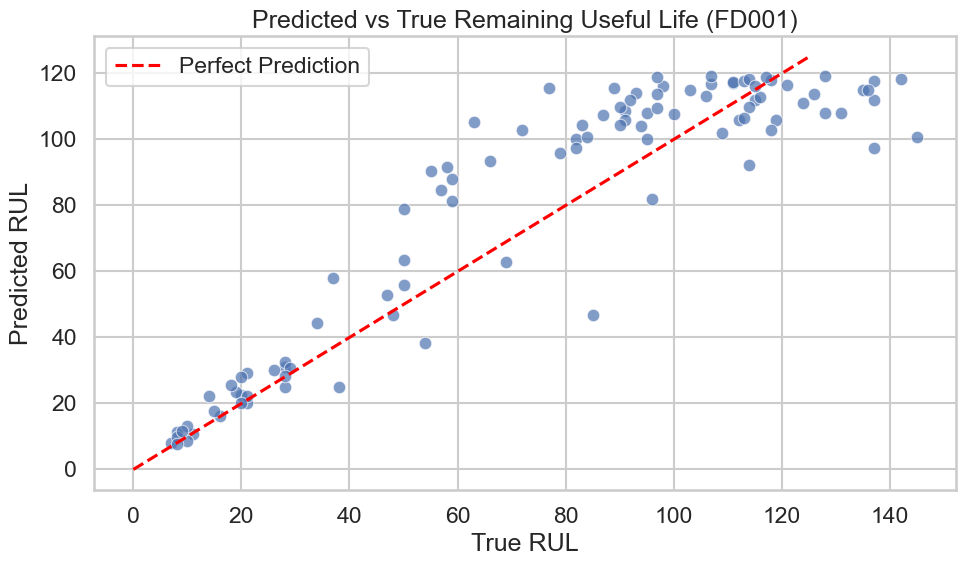

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=rul_df["RUL"],
    y=y_pred,
    alpha=0.7
)

plt.plot(
    [0, MAX_RUL],
    [0, MAX_RUL],
    color="red",
    linestyle="--",
    label="Perfect Prediction"
)

plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs True Remaining Useful Life (FD001)")
plt.legend()
plt.tight_layout()
plt.show()


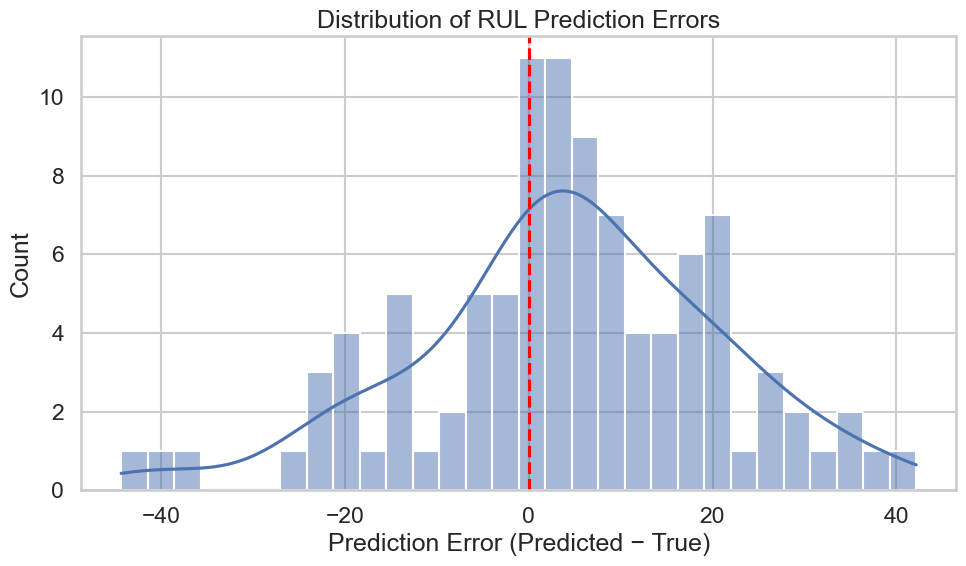

In [26]:
errors = y_pred - rul_df["RUL"]

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)

plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Prediction Error (Predicted − True)")
plt.title("Distribution of RUL Prediction Errors")
plt.tight_layout()
plt.show()


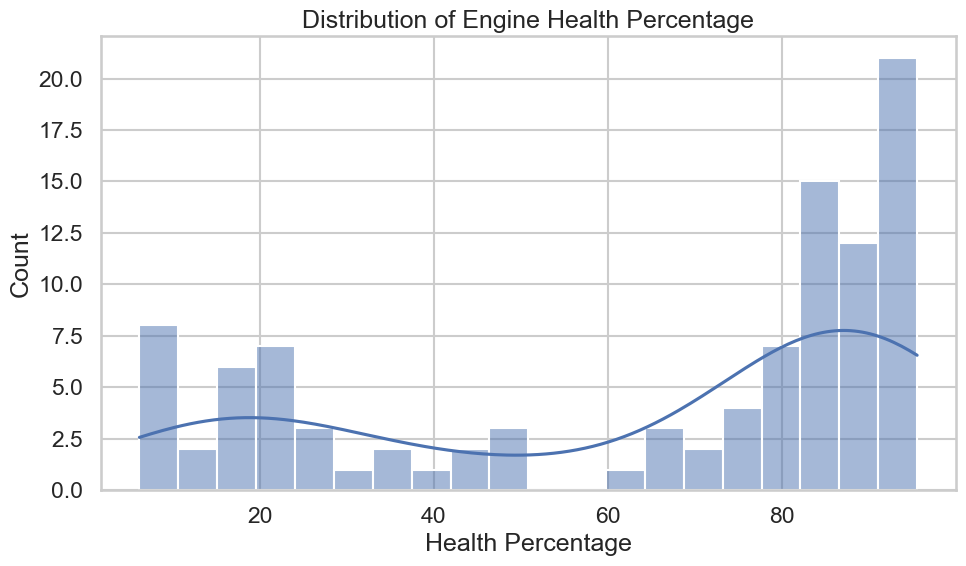

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(health_percent, bins=20, kde=True)

plt.xlabel("Health Percentage")
plt.ylabel("Count")
plt.title("Distribution of Engine Health Percentage")
plt.tight_layout()
plt.show()


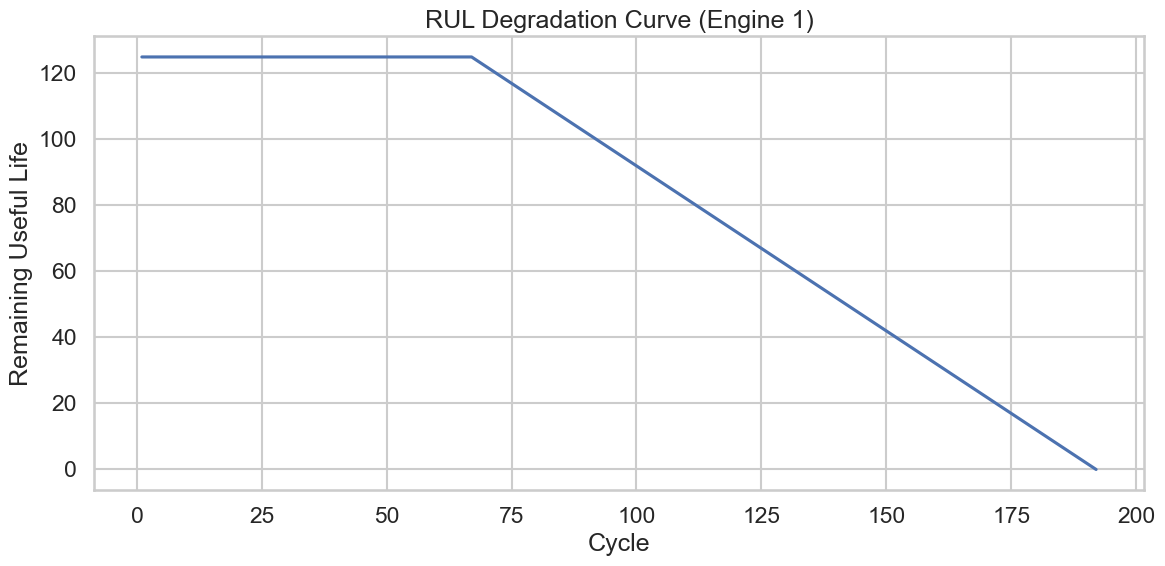

In [28]:
engine_id = 1  # change to any engine ID

engine_data = train_df[train_df["engine_id"] == engine_id]

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data["RUL"]
)

plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title(f"RUL Degradation Curve (Engine {engine_id})")
plt.tight_layout()
plt.show()



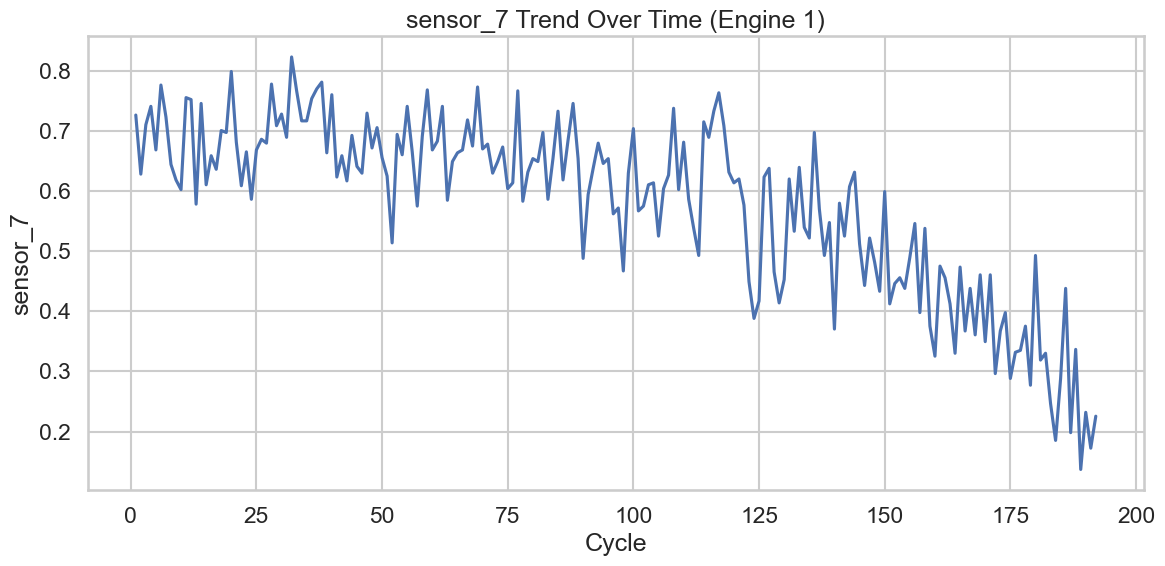

In [29]:
sensor_name = "sensor_7"  # choose any kept sensor

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=engine_data["cycle"],
    y=engine_data[sensor_name]
)

plt.xlabel("Cycle")
plt.ylabel(sensor_name)
plt.title(f"{sensor_name} Trend Over Time (Engine {engine_id})")
plt.tight_layout()
plt.show()
